# Temporal and spatial smoothing

This demo demonstrates `climpred`'s capabilities to postprocess decadal prediction output before skill verification.
Here, we showcase a set of methods to smooth out noise in the spatial and temporal domain.

In [1]:
import warnings
%matplotlib inline
import climpred
warnings.filterwarnings("ignore")

In [2]:
# Sea surface temperature
varname='tos'
ds3d = climpred.tutorial.load_dataset('MPI-PM-DP-3D')[varname]
control3d = climpred.tutorial.load_dataset('MPI-control-3D')[varname]

`climpred` requires that `lead` dimension has an attribute called `units` indicating what time units the `lead` is assocated with.  Options are: `years,seasons,months,weeks,pentads,days`.  For the this data, the `lead` `units` are `years`. 

In [3]:
ds3d['lead'].attrs={'units': 'years'}

## Temporal smoothing

In order to reduce temporal noise, decadal predictions are recommended to take multi-year averages [Goddard2013].

In [4]:
ds3d_ts = climpred.smoothing.temporal_smoothing(ds3d,smooth_kws={'lead':4})
control3d_ts = climpred.smoothing.temporal_smoothing(control3d, smooth_kws={'time':4})

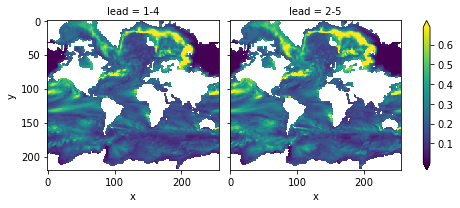

In [5]:
climpred.prediction.compute_perfect_model(ds3d_ts,
                                          control3d_ts, 
                                          metric='rmse', 
                                          comparison='m2e') \
                   .plot(col='lead', robust=True, yincrease=False)

Compare to without smoothing:

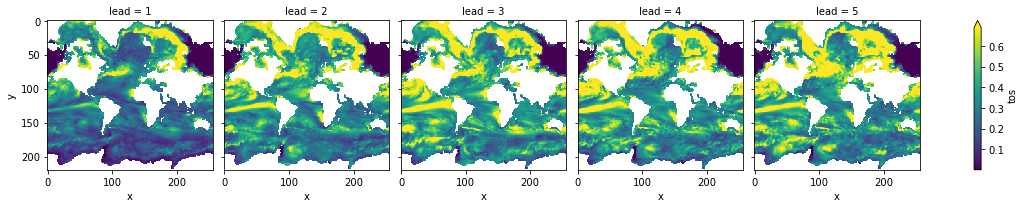

In [6]:
climpred.prediction.compute_perfect_model(ds3d,
                                          control3d, 
                                          metric='rmse', 
                                          comparison='m2e') \
                   .plot(col='lead', vmax=.69, yincrease=False)

Note: When using `temporal_smoothing` on compute_hindcast, set rename_dim=False and after calculating the skill `_reset_temporal_axis` to get proper labeling of the lead dimension.

In [7]:
hind = climpred.tutorial.load_dataset('CESM-DP-SST-3D').load()['SST']
reconstruction = climpred.tutorial.load_dataset('FOSI-SST-3D').load()['SST']
# get anomaly reconstruction
reconstruction = reconstruction - reconstruction.mean('time')

In [8]:
hind_ts = climpred.smoothing.temporal_smoothing(hind,smooth_kws={'lead':4},rename_dim=False)
reconstruction_ts = climpred.smoothing.temporal_smoothing(reconstruction, smooth_kws={'time':4},rename_dim=False)

In [9]:
# Lose units attribute along the way.
hind_ts["lead"].attrs["units"] = "years"

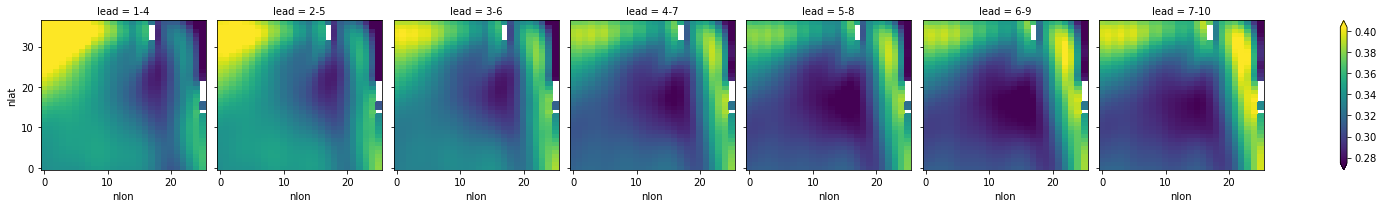

In [10]:
s = climpred.prediction.compute_hindcast(hind_ts,
                                          reconstruction_ts, 
                                          metric='rmse', 
                                          comparison='e2r')
s = climpred.smoothing._reset_temporal_axis(s,smooth_kws={'lead':4})
s.plot(col='lead', robust=True)

## Spatial smoothing
In order to reduce spatial noise, global decadal predictions are recommended to get regridded to a 5 degree longitude x 5 degree latitude grid as recommended [Goddard2013].

In [11]:
ds3d_ss = climpred.smoothing.spatial_smoothing_xesmf(ds3d,d_lon_lat_kws={'lon':5, 'lat':5})
control3d_ss = climpred.smoothing.spatial_smoothing_xesmf(control3d, d_lon_lat_kws={'lon':5,'lat':5})

Create weight file: bilinear_220x256_36x73.nc
Reuse existing file: bilinear_220x256_36x73.nc


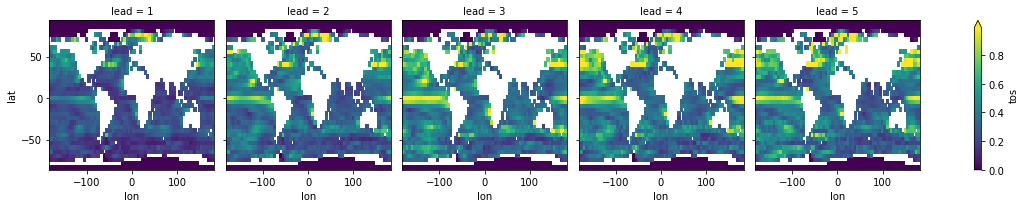

In [12]:
climpred.prediction.compute_perfect_model(ds3d_ss,
                                          control3d_ss, 
                                          metric='rmse', 
                                          comparison='m2e') \
                   .plot(col='lead', robust=True, yincrease=True)

Alternatively, also `climpred.smoothing.spatial_smoothing_xrcoarsen` aggregates gridcells like `xr_coarsen`.

`smooth_goddard2013` creates 4-year means and 5x5 degree regridding as suggested in [Goddard2013].

In [13]:
climpred.smoothing.smooth_goddard_2013(ds3d).coords

Reuse existing file: bilinear_220x256_36x73.nc


Coordinates:
  * lead     (lead) <U3 '1-4' '2-5'
  * init     (init) int64 3014 3061 3175 3237
  * member   (member) int64 1 2 3 4
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 170.0 175.0 180.0
  * lat      (lat) float64 -83.97 -78.97 -73.97 -68.97 ... 81.03 86.03 91.03

## References

1. Goddard, L., A. Kumar, A. Solomon, D. Smith, G. Boer, P. Gonzalez, V. Kharin, et al. “A Verification Framework for Interannual-to-Decadal Predictions Experiments.” Climate Dynamics 40, no. 1–2 (January 1, 2013): 245–72. https://doi.org/10/f4jjvf.
